In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from config import Config
import utils
import model as modellib
import visualize
from model import log
import prostate

%matplotlib inline

# GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Using TensorFlow backend.


In [2]:
dataset_dir = "/scratch/wenyuan/Mask-RCNN/Data_Pre_Processing/cedars-224"
held_out_set = 4
mean_pixel = prostate.Mean_pixel(dataset_dir, held_out_set)
class InferenceConfig(prostate.ProstateConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 1     
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MAX_INSTANCES = 200
    MEAN_PIXEL = np.array(mean_pixel)
    POST_NMS_ROIS_INFERENCE = 1000

inference_config = InferenceConfig()
inference_config.display()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]

# model_path = model.find_specific(epoch = 9, held_out_set = 4)[1]
model_path = model.find_specific(epoch = 160, held_out_set = 4)[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        1
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 193.97800579  120.89113632  183.79060979]
MINI_MASK_SHAPE                (56, 56)
NAME                           prostate
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROI

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
def instance_2_sementic(instance_mask, class_ids):
    try:
        h, w, d = instance_mask.shape
    except ValueError:
        mask = int(class_ids) * instance_mask 
        result_dict = {'ATmask': mask}
        return result_dict
    
    mask_map = {}
    for index, label in enumerate(class_ids):
        mask_map[str(label)] = np.logical_or(mask_map[str(label)], \
                                             instance_mask[:, :, index]) \
        if str(label) in mask_map.keys() else instance_mask[:, :, index]
    
    mask = np.zeros((h, w), dtype=np.int)

    for key in mask_map.keys():
        if (key != '0'):
            mask = mask + int(key) * mask_map[key] 
    result_dict = {'ATmask': mask}
    return result_dict

In [5]:
def prediction_2_sementic(mask, class_ids, scores):
    """ convert maskrcnn prediction to 1 single sementic mask
    """
    mask_map = {} # create a probability dict for each class
    for index, label in enumerate(class_ids):
        mask_map[str(label)] = \
        np.maximum(mask_map[str(label)], scores[index] * mask[:, :, index])\
        if str(label) in mask_map.keys() else scores[index] * mask[:, :, index]
    
    ## convert to h * w * num_classes probability map
    h, w, d = mask.shape
    for i in range(4):
        try:
            sementic_mask = \
            np.concatenate((sementic_mask, \
                            np.expand_dims(mask_map[str(i)], axis = -1)),axis = -1)\
            if (i != 0) else np.expand_dims(mask_map[str(i)], axis = -1)
        except KeyError:
            sementic_mask = np.concatenate((sementic_mask, np.zeros((h, w, 1))),axis = -1)\
            if (i != 0) else np.zeros((h, w, 1))
            
    sementic_mask_res = np.argmax(sementic_mask, axis = -1)
    return sementic_mask_res

In [6]:
def compute_mIOU(c_matrix):
    """ compute the mIOU based on the confusion matrix
    """
    num_class, _ = c_matrix.shape
    IOU = []
    for i in range(num_class):
        p = c_matrix[i, i] / (sum(c_matrix[i, :]) + sum(c_matrix[:, i]) - c_matrix[i, i]) \
        if (sum(c_matrix[i, :]) + sum(c_matrix[:, i]) - c_matrix[i, i]) else 0
        IOU.append(p)
    return np.mean(IOU), IOU

In [7]:
dataset_val = prostate.ProstateDataset()
_, val_list = dataset_val.generator_patition(dataset_dir, held_out_set)
val_list = [1, 2, 3, 5]
dataset_val.load_prostate(dataset_dir, val_list)
dataset_val.prepare()

In [8]:
print(val_list, len(val_list))

[1, 2, 3, 5] 4


original_image           shape: (256, 256, 3)         min:    2.00000  max:  249.00000
image_meta               shape: (12,)                 min:    0.00000  max: 1200.00000
gt_class_id              shape: (12,)                 min:    0.00000  max:    3.00000
gt_bbox                  shape: (12, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 12)        min:    0.00000  max:    1.00000


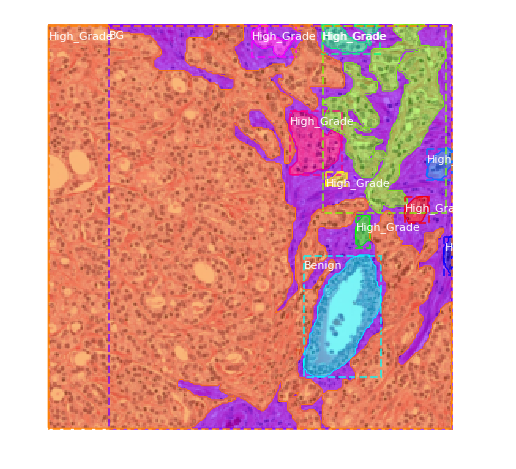

In [10]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 3
# print(val_list[image_id])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

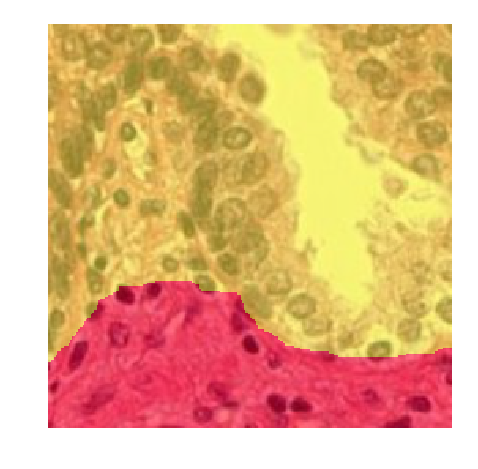

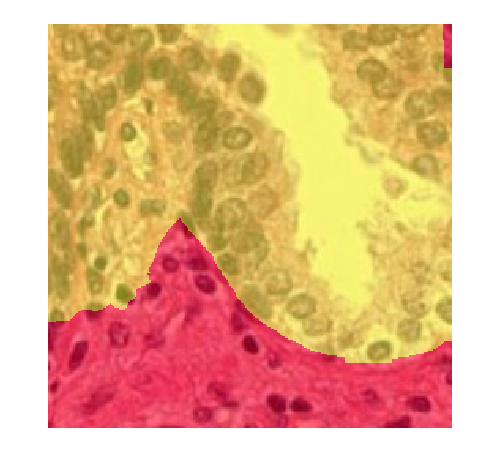

mIOU:  0.455002201909
IOU: [0.86965333333333328, 0, 0, 0.95035547430428602]


In [15]:
# Convert gt-instance mask to gt-sementic mask
gt_sementic_mask = instance_2_sementic(gt_mask, gt_class_id)

# Convert prediction to sementic mask
result_sementic = prediction_2_sementic(r['masks'], r['class_ids'], r['scores'])\
if r['class_ids'].size != 0 else np.zeros((original_image.shape[0], original_image.shape[1]))

# Visualization the sementic map
visualize.display_sementic(original_image, gt_sementic_mask['ATmask'],
                            figsize=(8, 8))
visualize.display_sementic(original_image, result_sementic,
                            figsize=(8, 8))


# Compute confusion matrix
c_matrix = confusion_matrix(np.ravel(gt_sementic_mask['ATmask']), np.ravel(result_sementic))
if c_matrix.size != 16:
    """if the confusion matrix is not 4 by 4
    """
    unique_set = \
    np.union1d(np.unique(result_sementic), np.unique(gt_sementic_mask['ATmask']))
    xv, yv = np.meshgrid(unique_set, unique_set)
    temp = np.zeros((4, 4))
    temp[yv.astype(int), xv.astype(int)] = c_matrix
    c_matrix = temp 

# Compute mIOU based on confusion matrix
mIOU, IOU = compute_mIOU(c_matrix)
print("mIOU: ", mIOU)
print("IOU:", IOU)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [17]:
for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    # Convert gt-instance mask to gt-sementic mask
    gt_sementic_mask = instance_2_sementic(gt_mask, gt_class_id)
    # Whether write the gt-sementic mask
#     save_sementic(gt_sementic_mask, val_list[image_id], dataset_dir)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Convert prediction to sementic mask
    result_sementic = prediction_2_sementic(r['masks'], r['class_ids'], r['scores'])\
    if r['class_ids'].size != 0 else np.zeros((image.shape[0], image.shape[1]))
    # Compute confusion matrix
    c_matrix = confusion_matrix(np.ravel(gt_sementic_mask['ATmask']), np.ravel(result_sementic))
    if c_matrix.size != 16:
        """if the confusion matrix is not 4 by 4
        """
        unique_set = \
        np.union1d(np.unique(result_sementic), np.unique(gt_sementic_mask['ATmask']))
        xv, yv = np.meshgrid(unique_set, unique_set)
        temp = np.zeros((4, 4))
        temp[yv.astype(int), xv.astype(int)] = c_matrix
        c_matrix = temp 
    mIOU, IOU = compute_mIOU(c_matrix)
    cls_num = 0
    sum_iou = 0
    for element in IOU:
        if element != 0:
            sum_iou += element
            cls_num += 1
    if sum_iou / cls_num < 0.5:
        print('Look at %d / %d!'%(image_id, len(dataset_val.image_ids)), "IOU:", IOU)

# Compute mIOU based on confusion matrix
mIOU, IOU = compute_mIOU(C_MATRIX)
print("mIOU: ", mIOU)

Look at 5 / 576! IOU: [0.00072167428433966808, 0, 0, 0.87321837326415386]
Look at 6 / 576! IOU: [0.0062259116513489476, 0, 0, 0.94883614439441344]
Look at 36 / 576! IOU: [0.3104506121031459, 0, 0.0, 0.0]
Look at 37 / 576! IOU: [0.0021459227467811159, 0, 0, 0.93613319700276221]
Look at 39 / 576! IOU: [0.027525318099195013, 0, 0, 0.94276325844413877]
Look at 46 / 576! IOU: [0.18186292054402289, 0, 0, 0.70251012672642388]
Look at 47 / 576! IOU: [0.16693125511136769, 0, 0.0, 0.0]
Look at 48 / 576! IOU: [0.1537707020786962, 0, 0, 0.63503091441588022]
Look at 49 / 576! IOU: [0.11641764095156412, 0, 0, 0.68908937846466634]
Look at 50 / 576! IOU: [0.095740434509893363, 0, 0, 0.75166387396839818]
Look at 55 / 576! IOU: [0.021986353297952996, 0, 0, 0.96059745257949236]
Look at 58 / 576! IOU: [0.01461833185971117, 0, 0.0, 0.0]
Look at 59 / 576! IOU: [0.025286185936005432, 0, 0.0, 0.0]
Look at 68 / 576! IOU: [0.14781473886062801, 0, 0.0, 0.0]
Look at 69 / 576! IOU: [0.32917374030838159, 0, 0.0, 0.

ZeroDivisionError: division by zero